In [4]:
import numpy as np
import matplotlib
matplotlib.rcParams['text.usetex'] = True
import matplotlib.pyplot as plt
%matplotlib inline
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 15}

matplotlib.rc('font', **font)

import scipy.integrate as integrate

### Double well potential 


Text(0, 0.5, 'V(x)\np(x)')

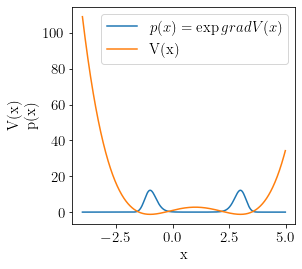

In [7]:
## Double well system
    
def potential(x):
    """
    potential of the double well
    """
    a=3
    return x**4/4-a*x**3/3-x**2/2+a*x+1 


def gradV(x):
    """
    function returns the value of gradient of V
    """
    a=3
    return x**3-x-a*x**2+a

def pX(x,s):
    """
    function returns the long term distribution of an double well SDE with inputs
    x: space
    a: parameters of the double well
    s: sigma parameter of the double well SDE
    return: 
    the distribution 
    """
    return np.exp(-potential(x)*2/s**2)


plt.figure(figsize=(4,4))
x=np.arange(-4,5,0.01)
plt.plot(x,pX(x,1),label="$$p(x) = \exp{ grad V(x)}$$")
plt.plot(x,potential(x),label="V(x)")
plt.legend()
plt.xlabel("x")
plt.ylabel("V(x)\np(x)")

## Double well SDE
### Reminder: Euler maruyama and evolving distribution

Just a reminder of what a double well SDEs with Euler Maruyama is supposed to produce 

In [8]:
# Paramters of the numerical scheme
M = 10**4 #number of draws
T=10 #until time T
N=10**(3) #time discretisation
a=3 #parameter of the double well potential
s = 1/10 #

Y0 = np.random.randint(-10,10,M) #initial condition
dt = 1/N #size of the time steps
tc=0 #value of the stochastic noise

while tc<T: #while we are not at time T of interest
    Y1 = np.zeros(M) # create a new vector Y1 to ensure that previous information is erased about Y1
    B1 = np.random.normal(0,s,M) # generate a random draw for the brownian noise
    Y1 = Y0 - gradV(Y0)*dt+s*B1 # one step in the numerical scheme
    tc+=dt
    del Y0
    Y0=Y1
    del Y1
    
    # save the distribution at different times 
    if np.round(tc,2) == 0.2:
        Y0_02=Y0
    if np.round(tc,2) == 0.5:
        Y0_05=Y0
    if np.round(tc,2) == 1:
        Y0_1=Y0
    if np.round(tc,2) == 5:
        Y0_5=Y0


 ### Plot evolving distribution 

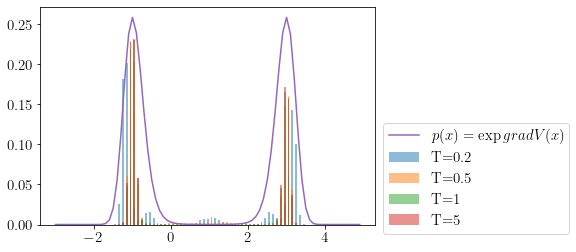

In [9]:
## Plot results on the simulation
def plot_hist(arrayX):
    for i in range(len(arrayX)):
        if i==0:
            label_str="T=0.2"
        if i==1:
            label_str="T=0.5"        
        if i==2:
            label_str="T=1"       
        if i==3:
            label_str="T=5"
        X=arrayX[i]
        counts, edges = np.histogram(X, bins=np.arange(-3,5,0.1))
        counts = counts/np.sum(counts)
        
        plt.stairs(counts, edges, fill=True,alpha=0.5,label=label_str)
        plt.vlines(edges, 0, counts.max(), colors='w')

plot_hist([Y0_02,Y0_05,Y0_1,Y0_5])
bin_size=0.1
x=np.arange(-3,5,bin_size)
longterm_distr=pX(x,1)
plt.plot(x,longterm_distr/(np.sum(longterm_distr)*bin_size)/3.,label="$$p(x) = \exp{ grad V(x)}$$")
plt.legend(loc='upper left', bbox_to_anchor=(1, 0.5))


### Compute how long the simulation takes using simply python

In [10]:
M = 10**4 #number of draws
T=10 #until time T
N=10**(3) #time discretisation
a=3 #parameter of the double well potential
s = 1/10 #

def e_m(Y0,s,B1):
    """
    Euler-maruyama numerical scheme applied to the double well SDE
    """
    return Y0 - gradV(Y0)*dt+s*B1


def DW_sde(M,T,N,s,method):
    Y0 = np.random.randint(-10,10,M) #initial condition
    dt = 1/N #size of the time steps
    tc=0 #value of the stochastic noise
    while tc<T: #while we are not at time T of interest
        Y1 = np.zeros(M) # create a new vector Y1 to ensure that previous information is erased about Y1
        B1 = np.random.normal(0,s,M) # generate a random draw for the brownian noisec
         #thod(Y0,s)
        Y1 = method(Y0,s,B1) # one step in the numerical scheme
        tc+=dt
        Y0=Y1
    return(Y0)

In [11]:
%time DW_sde(M,T,N,s,e_m)


CPU times: user 6.45 s, sys: 47.1 ms, total: 6.5 s
Wall time: 6.52 s


array([-0.96272045, -0.78754453, -0.91854307, ..., -0.89890908,
       -1.00568118, -0.93331247])

### Compute how long the simulation takes using numba

In [12]:
from numba import jit,njit,vectorize, float64, int32
import numpy as np
import time

# define the gradV function 
@njit(float64(float64))
def gradV(x):
    gradVr = x**(3)-x-3*x**(2)+3
    return gradVr
    
@njit(float64(float64,float64,float64,float64))
def e_m_fast(y0,s,b1,dt):
    y1=y0 - gradV(y0)*dt+s*b1
    return y1
    
@njit(float64(float64,float64,float64))
def run_num(N,dt,s):
    y0 = np.random.normal(0,10,1)[0] #initial condition
    for ii in range(N):
        b1 = np.random.normal(0,s)
        y1 = e_m_fast(y0,s,b1,dt)
        y0=y1
    return y0

@njit(parallel=True)
def DW_sde_fast(n_samples,T,N,s): # Function is compiled and runs in machine code
    """
    Input
    -------
    n_samples: int
        Number of sample to draw
    T: int 
        Final time
    N: int
        Number of time steps 
    s: float
        Value of the variance of the DW SDE
    method: function
        Numerical scheme used for the DW SDE
    Return
    -------
    y_final: np.array
        Array of shape (M,). Sample of numerical approximation of the DW SDE at time T
    
    """
    dt = 0.001 #size of the time steps
    y_final = [] #np.zeros(n_samples)
    
    for i in range(n_samples):
        y0=run_num(N,dt,s)
        y_final.append(y0)
    y_final = np.array(y_final)
    return y_final


In [19]:
M = 10**4 #number of draws
T=10 #until time T
N=10**(3) #time discretisation
s = 1/10 #

# DO NOT REPORT THIS... COMPILATION TIME IS INCLUDED IN THE EXECUTION TIME!
start = time.time()
y1=DW_sde_fast(M,T,N,s)
end = time.time()
print("Elapsed (with compilation) = %s" % (end - start))

# NOW THE FUNCTION IS COMPILED, RE-TIME IT EXECUTING FROM CACHE
start = time.time()
y2=DW_sde_fast(M,T,N,s)
end = time.time()
print("Elapsed (after compilation) = %s" % (end - start))

Elapsed (with compilation) = 0.09651541709899902
Elapsed (after compilation) = 0.06382918357849121


In [14]:
%time DW_sde_fast(M,T,N,s)


CPU times: user 716 ms, sys: 3.98 ms, total: 720 ms
Wall time: 78.8 ms


array([-0.9926524 ,  2.89246292, -1.2033906 , ...,  2.99767621,
       -0.99719596,  3.12766874])

### Compare distributions: how to compare

In [25]:
X=y1
counts, edges = np.histogram(X, bins=np.arange(-3,5,0.1))
counts = counts/np.sum(counts)